# Seminar 2. Neuromorphic control
## In class:
* OpenAI Gym. Classic control environments.
* Observations, action, reward
* Neuro controller
* Add connections
* Parametric tuning

## Homework:
* Find input weights such that the controller achieves reward=200
* Explore the controller performance for "asymmetric" network where one of the neurons doesn't have sensor input and receives only synaptic connection from the other neuron.

### Optional:
* Create neurocontroller for continuous mountain car environment (https://gym.openai.com/envs/MountainCarContinuous-v0/). The continuous actions may be represented by firing rates (rate coding) or by neuron numbers (spatial coding).
* Optimize the controller parameters from scratch. You may use optimize.differential_evolution algorithm


### 1. OpenAI Gym
Here we explore the most basic environment, CartPole (https://gym.openai.com/envs/CartPole-v1/).

Observation: 
        Type: Box(4)
        
        Num	 Observation              Min             Max
        
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
Actions:
        Type: Discrete(2)
        
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
Reward:

        Reward is 1 for every step taken, including the termination step

In [28]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline

class RandomController:
    def __init__(self):
        self.action_space = gym.spaces.Discrete(2)
        
    def next_action(self, observation):
        # print(observation)
        return self.action_space.sample()
    
def control_cartpole(controller, show=True, print_log=True):
    env = gym.make("CartPole-v1") 
    obs = env.reset()
    R = 0
    if print_log:
        print("Step \t CartPosition CartVelocity PoleAngle PoleVelocity \t Action")
    for i in range(200):
        # plt.imshow(env.render(mode='rgb_array'))
        # display.display(plt.gcf())    
        # display.clear_output(wait=True)
        action = controller.next_action(obs)
        if print_log:
            print(f"{i}\t{obs[0]:12.4f}{obs[1]:12.4f}{obs[2]:12.4f}{obs[3]:12.4f}\t{action}")
        obs, reward, done, _ = env.step(action)
        R += reward
        if show:
            env.render()
        if done:
            break
    env.close()
    if print_log:
        print(f"Finished in {i+1} steps")
        print(f"Total reward = {R}")      
    return R

In [29]:
control_cartpole(RandomController())

32.0

### 2. Neuro controller
Here we create two LIF "motor neurons" for "Left" and "Right" actions.
The synaptic inputs come from the observations.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import brian2 as b2
import numpy as np
import random

class NeuroController:
    LEFT = 0
    RIGHT = 1
        
    def __init__(self, tau, w_sensor, I_tonic):
        # b2.start_scope() # clear the Brian scope
        eqs = '''
            dv/dt = (inp-v+I_t)/tau: 1
            inp : 1
            tau : second
            I_t : 1
            '''
        G = b2.NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='linear')
        self.neurons = G
        self.neurons.tau = tau
        self.neurons.v = [0,0]
        self.neurons.I_t = I_tonic
        self.w_sensor = w_sensor
        self.T_step = 1/50 * b2.second
        self.spike_mon = b2.SpikeMonitor(G)
        self.v_mon = b2.StateMonitor(G, "v", record=True)
        self.net = b2.Network(self.neurons, self.spike_mon, self.v_mon)
    
    def next_action(self, observation):
        self.neurons.inp = observation@self.w_sensor
        prev_spikes = np.array(self.spike_mon.count)
        self.net.run(self.T_step)
        new_spikes = self.spike_mon.count - prev_spikes
        left = new_spikes[NeuroController.LEFT]
        right = new_spikes[NeuroController.RIGHT]
        if right > left:
            return NeuroController.RIGHT
        elif right < left:
            return NeuroController.LEFT
        else:
            return random.randrange(2)


### 3. Input weights and tonic drive

* explore how sensor weights influence control
* add tonic drive current I_ton to both neurons

#### Hint: 
The important parameters are CartVelocity and PoleAngle

In [31]:
def plot_v_spikes(v_mon, s_mon, t_bounds=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    b2.plot(v_mon.t/b2.ms, v_mon.v[0], label='left')
    b2.plot(v_mon.t/b2.ms, v_mon.v[1], label='right')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num') 

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	 Action
0	      0.0067      0.0008     -0.0397     -0.0419	0
1	      0.0067     -0.1937     -0.0405      0.2380	0
2	      0.0028     -0.3882     -0.0358      0.5176	1
3	     -0.0049     -0.1926     -0.0254      0.2138	1
4	     -0.0088      0.0029     -0.0211     -0.0867	0
5	     -0.0087     -0.1919     -0.0229      0.1992	1
6	     -0.0126      0.0035     -0.0189     -0.1006	0
7	     -0.0125     -0.1914     -0.0209      0.1860	1
8	     -0.0163      0.0041     -0.0172     -0.1132	0
9	     -0.0163     -0.1908     -0.0195      0.1741	1
10	     -0.0201      0.0046     -0.0160     -0.1247	0
11	     -0.0200     -0.1903     -0.0185      0.1629	1
12	     -0.0238      0.0051     -0.0152     -0.1356	0
13	     -0.0237     -0.1898     -0.0179      0.1523	1
14	     -0.0275      0.0056     -0.0149     -0.1460	0
15	     -0.0274     -0.1894     -0.0178      0.1420	1
16	     -0.0312      0.0060     -0.0150     -0.1563	0
17	     -0.0310     -0.1889

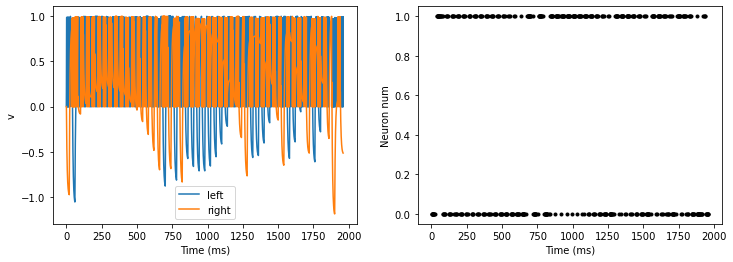

In [32]:
from numpy.random import default_rng
rng = default_rng()
b2.start_scope()
tau = [5*b2.ms, 5*b2.ms]

# Vary the weight from -1(1) to -100 (100)
#observation = [CartPosition, CartVelocity, PoleAngle, PoleVelocity]
#action
w_sensor = np.array([[0, 10, -50, 0],
                     [0, -10,  50, 0]]).T
I_tonic = 1
controller = NeuroController(tau, w_sensor, I_tonic)

# Add tonic current I_t to neurons in NeuroController like that:
# I_tonic = 1
# controller = NeuroController(tau, w_sensor, I_tonic)

control_cartpole(controller)
plot_v_spikes(controller.v_mon, controller.spike_mon)

### Control by a half-center oscillator
* Add inhibitory synapses to the controller network
* Explore how mutual inhibition influence control
* Cut sensor inputs to one of the neurons

In [33]:
class HCOController(NeuroController):
        
    def __init__(self, tau, w_sensor, w_syn, I_tonic):
        NeuroController.__init__(self, tau, w_sensor, I_tonic)
        self.neurons.add_attribute("w_syn")
        self.neurons.w_syn = w_syn
        S = b2.Synapses(self.neurons, self.neurons, on_pre='v_post += w_syn')
        S.connect(i=0, j=1)
        S.connect(j=0, i=1)
        self.net.add(S)

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	 Action
0	     -0.0446     -0.0493      0.0016      0.0349	1
1	     -0.0456      0.1458      0.0023     -0.2573	0
2	     -0.0427     -0.0493     -0.0029      0.0361	1
3	     -0.0437      0.1458     -0.0021     -0.2575	0
4	     -0.0407     -0.0493     -0.0073      0.0345	1
5	     -0.0417      0.1460     -0.0066     -0.2604	0
6	     -0.0388     -0.0491     -0.0118      0.0302	0
7	     -0.0398     -0.2440     -0.0112      0.3191	1
8	     -0.0447     -0.0487     -0.0048      0.0229	1
9	     -0.0456      0.1465     -0.0044     -0.2713	0
10	     -0.0427     -0.0486     -0.0098      0.0200	1
11	     -0.0437      0.1467     -0.0094     -0.2757	0
12	     -0.0408     -0.0483     -0.0149      0.0140	0
13	     -0.0417     -0.2432     -0.0146      0.3019	1
14	     -0.0466     -0.0479     -0.0086      0.0047	1
15	     -0.0475      0.1473     -0.0085     -0.2907	0
16	     -0.0446     -0.0477     -0.0143     -0.0007	0
17	     -0.0456     -0.2426

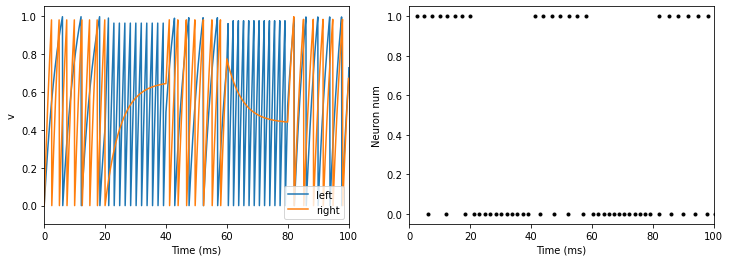

In [34]:
rng = default_rng()
b2.start_scope()
tau = [5*b2.ms, 5*b2.ms]

w_sensor = np.array([[0, 10, -50, 0],
                     [0, -10,  50, 0]]).T
w_syn = -1
I_tonic = 2
controller = HCOController(tau, w_sensor, w_syn, I_tonic)

control_cartpole(controller)
plot_v_spikes(controller.v_mon, controller.spike_mon, t_bounds=(0, 100))

### Parametric tuning
Here we will find optimal parameters for the controller by an optimization algorithm.
For tuning networks with small number of parameters you may use grid search.
For more complex networks we may use some optimization library:
1. Hyperopt (https://hyperopt.github.io/hyperopt/)
2. scipy.optimize (https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

In [40]:
def create_controller(x):
    b2.start_scope()
    tau = [5*b2.ms, 5*b2.ms]
    I_tonic = x[0]
    w_syn = x[1]
    w_sensor = np.array([[0, 10, -50, 0],
                     [0, -10,  50, 0]]).T
    return HCOController(tau, w_sensor, w_syn, I_tonic)
    

def obj_fun(x, num_run = 1):
    total_R = 0
    for _ in range(num_run):
        total_R += control_cartpole(create_controller(x), 
                                    show=False, print_log=False)
    return total_R/num_run

In [ ]:
from scipy import optimize as opt
#How grid search works:
I_t = [0,1,2]
w_syn = [-1, -0.5, -0.25, 0]
F = []
for i_t in I_t:
    for w_s in w_syn: 
        F += [(i_t, w_s, obj_fun([i_t, w_s], num_run=3))]
print(F)
best = max(F, key=lambda x: x[2])
print(f"Best solution: I_tonic={best[0]}, w_syn={best[1]}. Reward={best[2]}")

In [48]:
# How evolutionary algorithm works (slowly!):
bounds = [(0,3),(-1,0)]
res = opt.differential_evolution(obj_fun, bounds)
print(f"Best solution: I_tonic={res.x[0]}, w_syn={res.x[1]}. Reward={res.fun[end]}")
res_hco = create_controller(res.x)
control_cartpole(res_hco, show=True, print_log=False)
plot_v_spikes(controller.v_mon, controller.spike_mon)

KeyboardInterrupt: 